In [1]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip

--2023-11-16 05:53:00--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  31.2MB/s    in 1.6s    

2023-11-16 05:53:02 (31.2 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

In [4]:
class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms):
    self.root =root
    self.transforms = transforms

    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

    img = read_image(img_path)
    mask = read_image(mask_path)

    # instances are encoded as different colors
    obj_ids = torch.unique(mask)
    #print(f"mask shape: {mask.shape}; obj_ids shape: {obj_ids.shape}")
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    num_objs = len(obj_ids)

    #print(f"obj_ids[:, None, None]: {obj_ids[:, None, None]}")

    # split the color-encoded mask into a set of binary masks
    masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
    #print(f"masks shape: {masks.shape}")

    # get bounding box coordinates for each mask
    boxes = masks_to_boxes(masks)
    #print(f"boxes shape: {boxes.shape}")

    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    #print(f"labels: {labels}")

    image_id = idx
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    #print(f"area: {area}")
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Wrap samp and targets into torchvision tv_tensors:
    img = tv_tensors.Image(img)

    target = {}
    target['boxes'] = tv_tensors.BoundingBoxes(boxes, format="XYXY",
                                               canvas_size=F.get_size(img))
    target['masks'] = tv_tensors.Mask(masks)
    target['labels'] = labels
    target['image_id'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

In [5]:
from torchvision.transforms import v2 as T


def get_transform(train):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  transforms.append(T.ToDtype(torch.float, scale=True))
  transforms.append(T.ToPureTensor())
  return T.Compose(transforms)

In [6]:
dataset = PennFudanDataset('PennFudanPed', get_transform(train=False))

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

images, targets = next(iter(data_loader))
# images = list(image for image in images)
# print(len(images))
# targets = [{k: v for k, v in t.items()} for t in targets]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


area: tensor([27160., 33228.])area: tensor([46332., 23800., 26182.])
area: tensor([32718., 23670., 30380., 24288., 10260.])area: tensor([29300.])


area: tensor([33640.])area: tensor([23680., 25456.])

area: tensor([28421., 42476.])
area: tensor([29993., 39893.])
area: tensor([40185.])
area: tensor([41756.])area: tensor([23850., 30294.,  1140.])

area: tensor([10788., 28000.])
area: tensor([30784.])
area: tensor([35670., 20424., 35746., 26568., 27775.])area: tensor([43550., 24253., 46080.])

area: tensor([30525., 35793.])area: tensor([28611., 24402., 34515.])

area: tensor([25740., 27000.])area: tensor([27448., 25721., 52272., 15925.])

area: tensor([33813., 37107., 35595.])
area: tensor([30709., 31360.])
area: tensor([28116., 13688.,  5198.])
area: tensor([34047.])area: tensor([44044.])

area: tensor([28017.])area: tensor([47658.])

area: tensor([44020.])
area: tensor([24108.])area: tensor([34428., 28060., 39072.])

area: tensor([41895.])area: tensor([31476., 37281., 47304.])area: ten

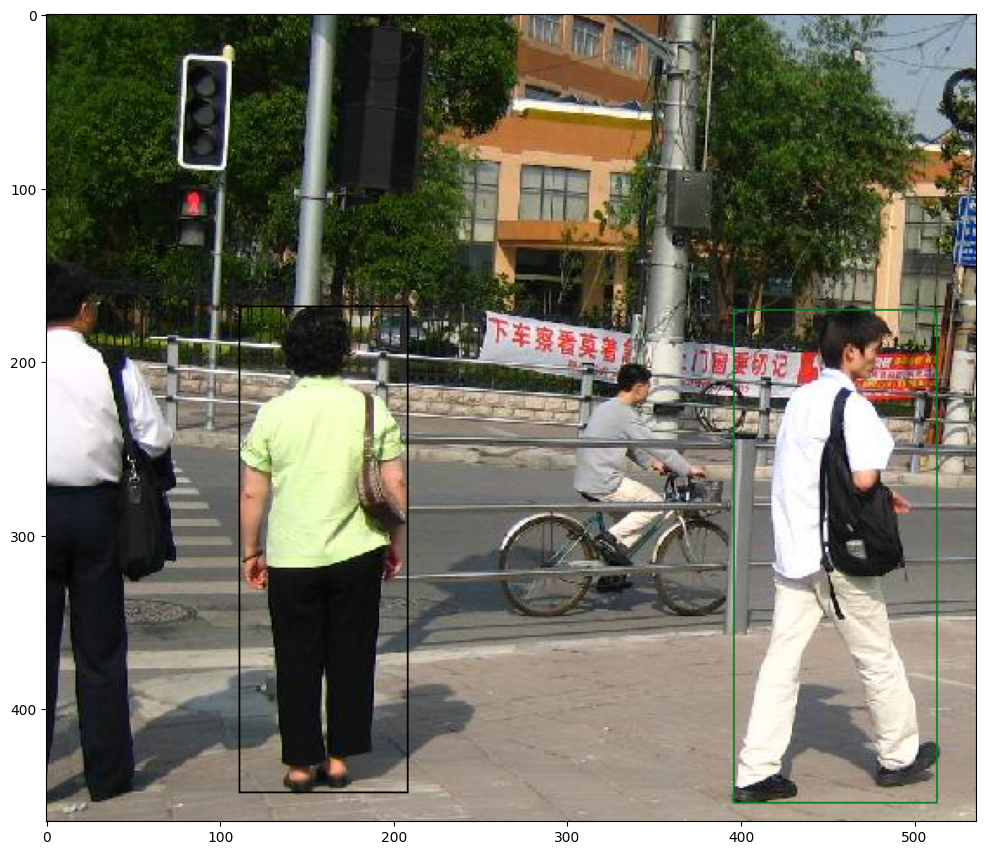

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = images[0]
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
output_image = draw_bounding_boxes(image, targets[0]['boxes'])

plt.figure(figsize=(12,12))
plt.imshow(output_image.permute(1, 2, 0))

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")


num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

model.to(device)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:02<00:00, 80.0MB/s]


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [9]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.0005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [10]:
import torch.distributed as dist

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True

In [11]:

def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

In [12]:

def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict

In [13]:
import math
import sys

def train_one_epoch(model, optimizer, data_loader, device, epoch):
  model.train()
  print(f"Epoch: [{epoch}]")

  lr_scheduler = None
  if epoch == 0:
      warmup_factor = 1.0 / 1000
      warmup_iters = min(1000, len(data_loader) - 1)

      lr_scheduler = torch.optim.lr_scheduler.LinearLR(
          optimizer, start_factor=warmup_factor, total_iters=warmup_iters
      )

  for batch_index, (images, targets) in enumerate(data_loader):
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
      with torch.cuda.amp.autocast(enabled=False):
          loss_dict = model(images, targets)
          losses = sum(loss for loss in loss_dict.values())

      # reduce losses over all GPUs for logging purposes
      loss_dict_reduced = reduce_dict(loss_dict)
      losses_reduced = sum(loss for loss in loss_dict_reduced.values())

      loss_value = losses_reduced.item()

      print(f"Epoch: {epoch}; Batch: {batch_index}; Total samples: {len(images)}; Loss is {loss_value}")

      if not math.isfinite(loss_value):
          print(f"Loss is {loss_value}, stopping training")
          print(loss_dict_reduced)
          sys.exit(1)

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()

      if lr_scheduler is not None:
          lr_scheduler.step()


In [14]:
# Let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch)
  # Update the learning rate
  lr_scheduler.step()
  # Evaluate on the test dataset


Epoch: [0]
area: tensor([25075.])
area: tensor([23600., 19359.])area: tensor([50904.])

area: tensor([30709., 31360.])
area: tensor([10788., 28000.])
area: tensor([38252.])
area: tensor([50286.])area: tensor([41895.])

area: tensor([43210.])
area: tensor([41748.])area: tensor([43350., 36722., 32940.])

area: tensor([29458., 27300., 28634.])area: tensor([34038.])

area: tensor([36564.,  3990.])area: tensor([31360., 27615., 31236.,  4284.])
area: tensor([26572.])

area: tensor([18660., 26877., 33411.])
area: tensor([25844., 30472.])
area: tensor([26220.])area: tensor([39744., 13311.,  2139.])
area: tensor([30784.])

area: tensor([46695.])
area: tensor([39530.])
area: tensor([23850., 30294.,  1140.])
area: tensor([23220., 33748., 29348.])
area: tensor([24854., 29458., 33600.])
area: tensor([43808., 35235., 19780., 12600.])area: tensor([37125., 32307., 23268.])

area: tensor([34080.])area: tensor([29295.])area: tensor([73390., 52096.])


area: tensor([30500., 19045., 29458., 21964.])area: 

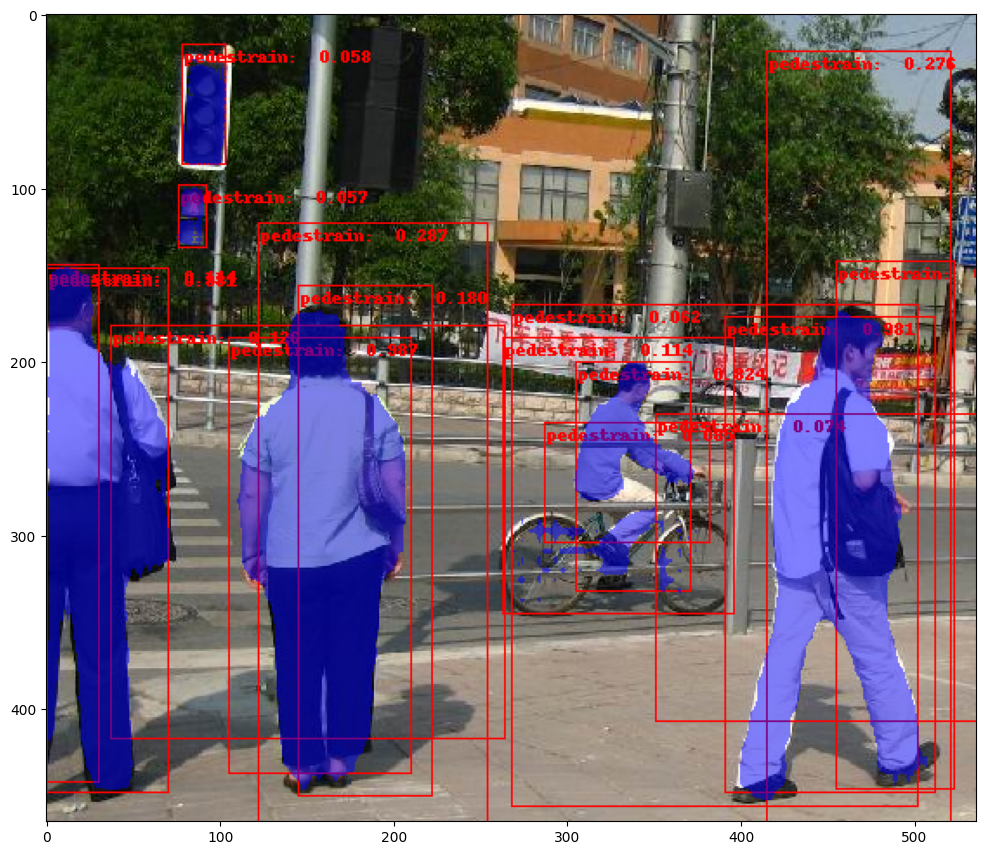

In [17]:
model.eval()

with torch.no_grad():
  x = get_transform(train=False)(images[0])
  # Convert RGBA -> RGB and move to device
  x = x[:3, ...].to(device)
  predictions = model([x, ])
  pred = predictions[0]


image = images[0]
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

pred_labels = [f"pedestrain: {score: .3f}" for label, score in zip(pred["labels"], pred['scores'])]
pred_bixes = pred["boxes"].long()

output_image = draw_bounding_boxes(image, pred_bixes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12,12))
plt.imshow(output_image.permute(1, 2, 0))